### Mixture Density Network

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from mdn import MixtureDensityNetwork, gmm_forward, get_argmax_mu, th2np
from jit_wrapper import save_jit_model
import os

# --- 1. Parameters & Configuration ---

In [9]:
# *** MODIFIED: This will now raise a FileNotFoundError if the file doesn't exist. ***
print("Loading training data 'training_data.npz'...")
train_data = np.load('../data1/noisy_data.npz')
x_train_np_orig = train_data['x']
y_train_np_orig = train_data['y']
print("Training data loaded successfully.")

N_SAMPLES = x_train_np_orig.shape[0]

print(f"Loaded {N_SAMPLES} training samples.")

Loading training data 'training_data.npz'...
Training data loaded successfully.
Loaded 800 training samples.


## --- 2. Data Preparation ---

In [10]:
# Reshape data for PyTorch
if x_train_np_orig.ndim == 1:
    x_train = x_train_np_orig.reshape(-1, 1)
else:
    x_train = x_train_np_orig

if y_train_np_orig.ndim == 1:
    y_train = y_train_np_orig.reshape(-1, 1)
else:
    y_train = y_train_np_orig
    
# Convert NumPy arrays to PyTorch Tensors
x_train_tensor = torch.tensor(x_train).float()
y_train_tensor = torch.tensor(y_train).float()

# Create a TensorDataset and DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# --- 4. Model Init and Loss Function and Optimizer ---

In [11]:
print(f"Initializing MDN")
model = MixtureDensityNetwork(
    name='mdn_for_outliers',
    x_dim=1,
    y_dim=1,
    k=3, 
    h_dim_list=[16,16,16], 
    actv=nn.Tanh(),                
    sig_max    = 2.0,
    mu_min     = -0.5,
    mu_max     = +0.5,
    p_drop=0.1
)
print(model)

# --- 4. Optimizer ---

# We DON'T define a 'criterion' (loss) here, it's calculated in the loop.
# We can still use weight_decay (L2 regularization) on the base network
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)

Initializing MDN
MixtureDensityNetwork(
  (actv): Tanh()
  (net): Sequential(
    (linear_00): Linear(in_features=1, out_features=16, bias=True)
    (tanh_01): Tanh()
    (dropout_02): Dropout(p=0.1, inplace=False)
    (linear_03): Linear(in_features=16, out_features=16, bias=True)
    (tanh_04): Tanh()
    (dropout_05): Dropout(p=0.1, inplace=False)
    (linear_06): Linear(in_features=16, out_features=16, bias=True)
    (tanh_07): Tanh()
    (dropout_08): Dropout(p=0.1, inplace=False)
    (mixturesofgaussianlayer_09): MixturesOfGaussianLayer(
      (fc_pi): Linear(in_features=16, out_features=3, bias=True)
      (fc_mu): Linear(in_features=16, out_features=3, bias=True)
      (fc_sigma): Linear(in_features=16, out_features=3, bias=True)
    )
  )
)


# --- 5. Training Loop ---

In [12]:
print("Starting MDN training...")
# Training Parameters
NUM_EPOCHS = 1000
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:
        
        # 1. Forward pass: Get the GMM parameters (pi, mu, sigma)
        pi_batch, mu_batch, sigma_batch = model(x_batch)
        
        # 2. Compute Loss: Calculate the Negative Log-Likelihood
        #    We use the 'gmm_forward' function we lifted
        out_dict = gmm_forward(pi_batch, mu_batch, sigma_batch, y_batch)
        nlls = out_dict['nlls'] # nlls is a tensor of shape [N]
        loss = torch.mean(nlls) # Our loss is the average NLL
        
        # 3. Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Print progress every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], NLL Loss: {epoch_loss/len(train_loader):.4f}')

print("Training finished.")

Starting MDN training...
Epoch [100/1000], NLL Loss: 0.4983
Epoch [200/1000], NLL Loss: 0.1182
Epoch [300/1000], NLL Loss: 0.0100
Epoch [400/1000], NLL Loss: 0.0073
Epoch [500/1000], NLL Loss: -0.0499
Epoch [600/1000], NLL Loss: -0.0922
Epoch [700/1000], NLL Loss: -0.0721
Epoch [800/1000], NLL Loss: -0.1316
Epoch [900/1000], NLL Loss: -0.1441
Epoch [1000/1000], NLL Loss: -0.1072
Training finished.


# --- 6. Visualization with Validation Data ---

Loading validation data 'validation_data.npz'...
Validation data loaded successfully.


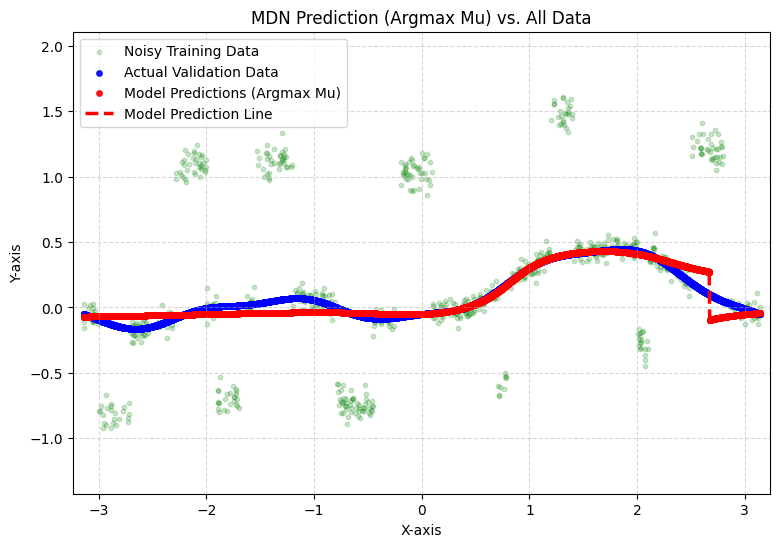

In [13]:
print("Loading validation data 'validation_data.npz'...")
val_data = np.load('../data1/clean_data.npz')
x_val = val_data['x']
y_val = val_data['y']
print("Validation data loaded successfully.")
    
# Prepare validation data (reshape and convert to tensor)
if x_val.ndim == 1: x_val = x_val.reshape(-1, 1)
if y_val.ndim == 1: y_val = y_val.reshape(-1, 1)

x_val_tensor = torch.tensor(x_val).float()

# Set model to evaluation mode
model.eval()

# Get model predictions for the validation set
with torch.no_grad():
    # 1. Get the full GMM parameters
    pi_val, mu_val, sigma_val = model(x_val_tensor)
    
    # 2. Get the *most probable* mean (our final prediction)
    #    This is the key! We are no longer using a single, overfitted output.
    y_val_pred_tensor = get_argmax_mu(pi_val, mu_val)

# Convert all data back to NumPy for plotting
y_val_pred_np = th2np(y_val_pred_tensor)
x_val_np = th2np(x_val_tensor)
y_val_np = y_val # Already a numpy array

# Create the scatter plot
plt.figure(figsize=(9, 6))

# Plot the original training data (with noise)
plt.scatter(x_train_np_orig, y_train_np_orig, color='green', label='Noisy Training Data', s=10, alpha=0.2)

# Plot the actual validation data (the "ground truth")
plt.scatter(x_val_np, y_val_np, color='blue', label='Actual Validation Data', s=15, alpha=0.9)

# Plot the model's predictions (The most probable mean)
plt.scatter(x_val_np, y_val_pred_np, color='red', label='Model Predictions (Argmax Mu)', s=15, alpha=0.9)

# Plot the prediction line
sort_indices = np.argsort(x_val_np.squeeze())
plt.plot(x_val_np[sort_indices], y_val_pred_np[sort_indices], color='red', linestyle='--', linewidth=2.5, label='Model Prediction Line')

plt.title('MDN Prediction (Argmax Mu) vs. All Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(y_train_np_orig.min() - 0.5, y_train_np_orig.max() + 0.5) # Set Y-limits
plt.xlim(x_train_np_orig.min() - 0.1, x_train_np_orig.max() + 0.1) # Set X-limits
plt.show()

# --- 6. Save JIT Model for Submission ---

In [14]:
print("\n--- Saving JIT Model ---")
# Ensure the 'model/' directory exists
os.makedirs('model', exist_ok=True)

# Set model to evaluation mode (turns off dropout, etc.)
model.eval()
JIT_MODEL_PATH = f"model/2025021851.pth"
# Save the JIT-scripted model
save_jit_model(model, JIT_MODEL_PATH)


--- Saving JIT Model ---
Wrapping model for JIT scripting...
JIT-scripted model saved successfully to model/2025021851.pth
